In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "waldo", "waldo")
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")

In [5]:
def load_images(waldo_path, full_pic_path, read_gray=False):
    if read_gray:
        # Read in grayscale
        template_gray = cv2.imread(waldo_path, cv2.IMREAD_GRAYSCALE)
        if template_gray is None:
            raise FileNotFoundError(f"Template image not found at: {waldo_path}")
        
        main_gray = cv2.imread(full_pic_path, cv2.IMREAD_GRAYSCALE)
        if main_gray is None:
            raise FileNotFoundError(f"Main image not found at: {full_pic_path}")
        return template_gray, main_gray
    else:
        # Read in BGR, then convert to RGB
        template_bgr = cv2.imread(waldo_path)
        if template_bgr is None:
            raise FileNotFoundError(f"Template image not found at: {waldo_path}")
        
        main_bgr = cv2.imread(full_pic_path)
        if main_bgr is None:
            raise FileNotFoundError(f"Main image not found at: {full_pic_path}")
        
        template_rgb = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2RGB)
        main_rgb = cv2.cvtColor(main_bgr, cv2.COLOR_BGR2RGB)
        return template_rgb, main_rgb

In [45]:
ROTATE_ANGLES = [0, 45, 90, 135, 180, 225, 270, 315]
SCALE_FACTOR = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

def rotate_image(image, angle, bg_color=(255, 255, 255)):
    """
    Rotate an image and auto-crop the resulting image to remove padded background.

    Args:
        image: Input image (grayscale or color)
        angle: Angle in degrees
        bg_color: Background color to fill (BGR or grayscale value)

    Returns:
        Cropped rotated image
    """
    if angle == 0:
        return image

    h, w = image.shape[:2]
    center = (w / 2, h / 2)

    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Get the new bounding dimensions
    abs_cos = abs(rot_mat[0, 0])
    abs_sin = abs(rot_mat[0, 1])
    bound_w = int(h * abs_sin + w * abs_cos)
    bound_h = int(h * abs_cos + w * abs_sin)

    # Adjust rotation matrix for translation
    rot_mat[0, 2] += bound_w / 2 - center[0]
    rot_mat[1, 2] += bound_h / 2 - center[1]

    # Perform rotation with padding
    rotated = cv2.warpAffine(
        image,
        rot_mat,
        (bound_w, bound_h),
        borderValue=bg_color
    )

    # Convert background to mask and crop around actual content
    if len(rotated.shape) == 3:
        mask = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    else:
        mask = rotated.copy()

    # Threshold to mask background
    _, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)

    cropped = rotated[y:y+h, x:x+w]
    return cropped


def scale_image(image, scale_factor):
    """
    Scale image by given factor
    
    Args:
        image: Input image
        scale_factor: Scale factor
        
    Returns:
        np.ndarray: Scaled image
    """
    if scale_factor == 1.0:
        return image
    
    if len(image.shape) == 2:  # Grayscale
        h, w = image.shape
    else:  # Color
        h, w = image.shape[:2]
    
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    
    scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    return scaled

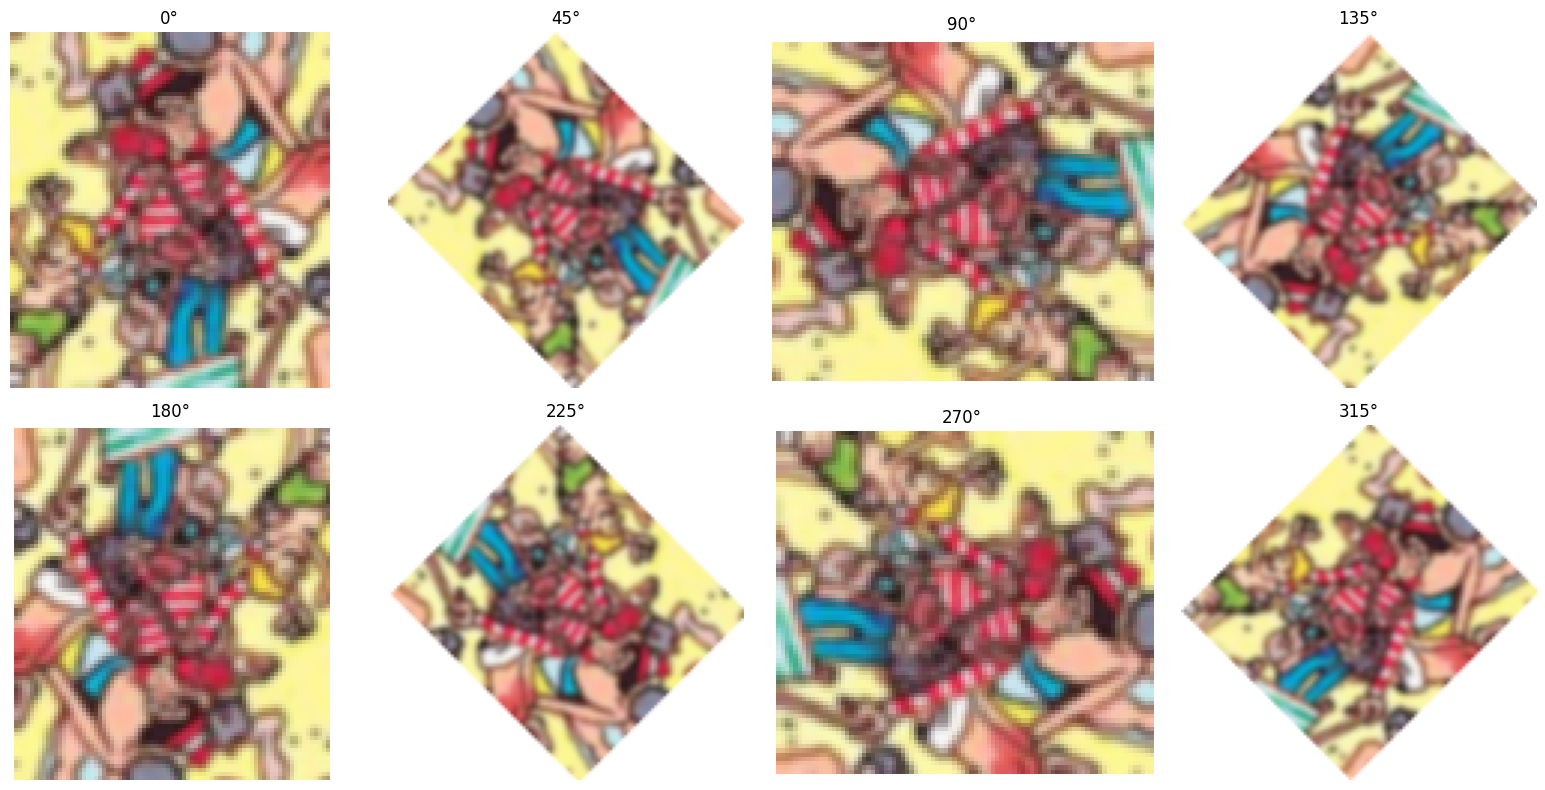

In [47]:
def visualize_rotated_templates(template, angles):
    """
    Rotate a template at given angles and plot them for inspection.
    
    Args:
        template (ndarray): The template image.
        angles (list of int): Rotation angles in degrees.
    """
    n = len(angles)
    cols = 4
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(4 * cols, 4 * rows))
    
    for i, angle in enumerate(angles):
        rotated = rotate_image(template, angle)
        plt.subplot(rows, cols, i + 1)
        if len(rotated.shape) == 2:  # Grayscale
            plt.imshow(rotated, cmap='gray')
        else:  # Color
            plt.imshow(rotated)
        plt.title(f"{angle}°")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_rotated_templates(processed_template, ROTATE_ANGLES)


In [9]:
def preprocess_images(template_img, main_img, kernel_size=(7, 7)):
    template_processed = cv2.GaussianBlur(template_img, kernel_size, 1.0)
    main_processed = cv2.GaussianBlur(main_img, kernel_size, 1.0)

    return template_processed, main_processed

In [37]:
def template_match(main_image, template, method=cv2.TM_CCOEFF_NORMED):
    """
    Perform single template matching
    
    Args:
        main_image: Main image to search in
        template: Template to find
        method: OpenCV template matching method
        
    Returns:
        dict: Match results
    """
    # Perform template matching
    result = cv2.matchTemplate(main_image, template, method)
    
    # Find the best match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # For correlation methods, higher values are better
    if method in [cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR_NORMED]:
        correlation_value = max_val
        location = max_loc
    else:
        correlation_value = 1 - min_val  # Convert to similarity measure
        location = min_loc
    
    return {
        'correlation': correlation_value,
        'location': location,
        'result_matrix': result
    }

def cross_correlation_matching_multi_transform(template_processed, main_processed, 
                                               method=cv2.TM_CCOEFF_NORMED,
                                               threshold=0.8,
                                               min_distance=20):
    """
    Perform cross-correlation template matching with rotation and scale variations
    and return all match locations above a threshold, filtered to remove near-duplicates.
    
    Args:
        template_processed: Processed template image
        main_processed: Processed main image
        rotation_angles: List of angles to try
        scale_factors: List of scale factors to try
        method: OpenCV template matching method
        threshold: Correlation threshold for detecting matches
        min_distance: Minimum distance to separate two distinct detections
        
    Returns:
        list of dicts: Each dict contains info about a found Waldo
    """
    rotation_angles = ROTATE_ANGLES
    scale_factors = SCALE_FACTOR

    all_matches = []
    total_combinations = len(rotation_angles) * len(scale_factors)
    current_combination = 0

    print(f"Testing {len(rotation_angles)} rotation angles and {len(scale_factors)} scale factors...")
    print(f"Total combinations to test: {total_combinations}")

    start_time = time.time()
    
    for angle in rotation_angles:
        for scale in scale_factors:
            current_combination += 1
            print(f"Testing combination {current_combination}/{total_combinations}: "
                  f"Angle={angle}°, Scale={scale:.1f}")
            
            # Transform template
            transformed_template = scale_image(template_processed, scale)
            transformed_template = rotate_image(transformed_template, angle)

            # Skip if template is invalid
            if transformed_template.shape[0] >= main_processed.shape[0] or \
               transformed_template.shape[1] >= main_processed.shape[1] or \
               transformed_template.shape[0] < 5 or transformed_template.shape[1] < 5:
                continue

            # Match
            result_matrix = cv2.matchTemplate(main_processed, transformed_template, method)
            
            # Find all match locations above threshold
            loc = np.where(result_matrix >= threshold)
            for pt in zip(*loc[::-1]):  # (x, y)
                correlation = result_matrix[pt[1], pt[0]]

                # Check if this point is too close to any already accepted match
                is_duplicate = False
                for existing in all_matches:
                    existing_pt = np.array(existing['location'])
                    if np.linalg.norm(np.array(pt) - existing_pt) < min_distance:
                        is_duplicate = True
                        break

                if not is_duplicate:
                    match_info = {
                        'angle': angle,
                        'scale': scale,
                        'location': pt,
                        'correlation': correlation,
                        'template_size': transformed_template.shape
                    }
                    all_matches.append(match_info)

    end_time = time.time()

    print(f"amount of time took to look for all waldo configs = {end_time - start_time}")

    print(f"\nTotal non-duplicate matches found above threshold ({threshold}): {len(all_matches)}")
    return all_matches

In [39]:
def draw_all_matches(image, matches, color=(0, 0, 255), thickness=6):
    """
    Draw rectangles for all matches on an image using matplotlib (RGB format).

    Args:
        image: Original image (BGR or RGB).
        matches: List of match dictionaries.
        color: Tuple for rectangle color (R, G, B).
        thickness: Thickness of rectangle.

    Returns:
        Displays the image with matches using matplotlib.
    """
    img_copy = image.copy()
    
    for match in matches:
        top_left = match['location']
        h, w = match['template_size'][:2]
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(img_copy, top_left, bottom_right, color, thickness)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_copy)
    plt.title(f'Matches found: {len(matches)}')
    plt.axis('off')
    plt.show()


In [41]:
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")
template_rgb, main_image_rgb = load_images(waldo_path, full_pic_path, read_gray=False)
processed_template, processed_main = preprocess_images(template_rgb, main_image_rgb)

results = cross_correlation_matching_multi_transform(processed_template, processed_main, threshold=0.6)


Testing 8 rotation angles and 8 scale factors...
Total combinations to test: 64
Testing combination 1/64: Angle=0°, Scale=0.8
Testing combination 2/64: Angle=0°, Scale=0.9
Testing combination 3/64: Angle=0°, Scale=1.0
Testing combination 4/64: Angle=0°, Scale=1.1
Testing combination 5/64: Angle=0°, Scale=1.2
Testing combination 6/64: Angle=0°, Scale=1.3
Testing combination 7/64: Angle=0°, Scale=1.4
Testing combination 8/64: Angle=0°, Scale=1.5
Testing combination 9/64: Angle=45°, Scale=0.8
Testing combination 10/64: Angle=45°, Scale=0.9
Testing combination 11/64: Angle=45°, Scale=1.0
Testing combination 12/64: Angle=45°, Scale=1.1
Testing combination 13/64: Angle=45°, Scale=1.2
Testing combination 14/64: Angle=45°, Scale=1.3
Testing combination 15/64: Angle=45°, Scale=1.4
Testing combination 16/64: Angle=45°, Scale=1.5
Testing combination 17/64: Angle=90°, Scale=0.8
Testing combination 18/64: Angle=90°, Scale=0.9
Testing combination 19/64: Angle=90°, Scale=1.0
Testing combination 20/64

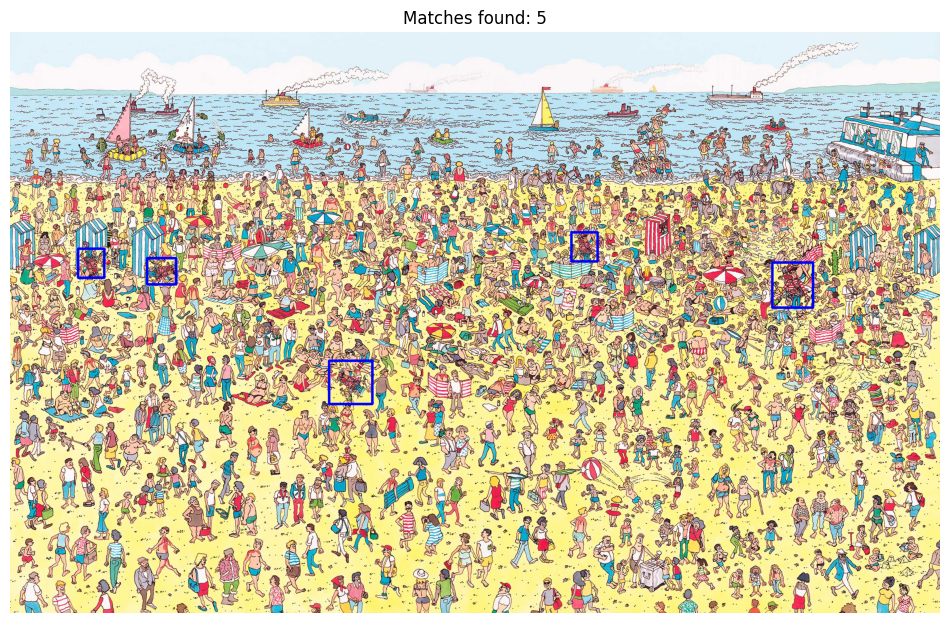

In [35]:
draw_all_matches(main_image_rgb, results)

In [51]:
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")
template_grey, main_image_grey = load_images(waldo_path, full_pic_path, read_gray=True)
processed_template_grey, processed_main_grey = preprocess_images(template_grey, main_image_grey)

results_grey = cross_correlation_matching_multi_transform(processed_template_grey, processed_main_grey, threshold=0.6)


Testing 8 rotation angles and 8 scale factors...
Total combinations to test: 64
Testing combination 1/64: Angle=0°, Scale=0.8
Testing combination 2/64: Angle=0°, Scale=0.9
Testing combination 3/64: Angle=0°, Scale=1.0
Testing combination 4/64: Angle=0°, Scale=1.1
Testing combination 5/64: Angle=0°, Scale=1.2
Testing combination 6/64: Angle=0°, Scale=1.3
Testing combination 7/64: Angle=0°, Scale=1.4
Testing combination 8/64: Angle=0°, Scale=1.5
Testing combination 9/64: Angle=45°, Scale=0.8
Testing combination 10/64: Angle=45°, Scale=0.9
Testing combination 11/64: Angle=45°, Scale=1.0
Testing combination 12/64: Angle=45°, Scale=1.1
Testing combination 13/64: Angle=45°, Scale=1.2
Testing combination 14/64: Angle=45°, Scale=1.3
Testing combination 15/64: Angle=45°, Scale=1.4
Testing combination 16/64: Angle=45°, Scale=1.5
Testing combination 17/64: Angle=90°, Scale=0.8
Testing combination 18/64: Angle=90°, Scale=0.9
Testing combination 19/64: Angle=90°, Scale=1.0
Testing combination 20/64

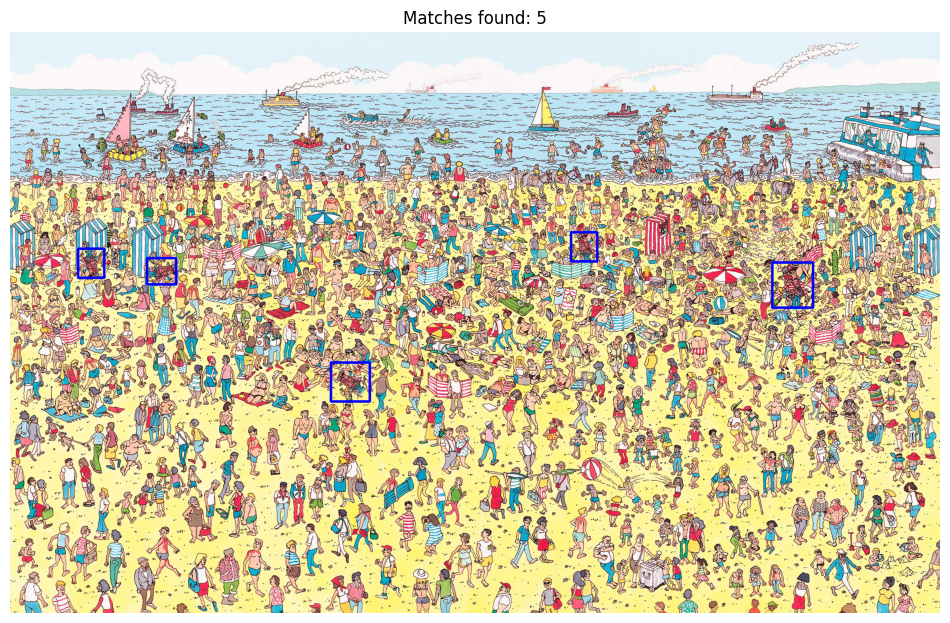

In [53]:
draw_all_matches(main_image_rgb, results_grey)

In [81]:
def pyramid_template_matching(template, image, 
                              num_levels=3,
                              method=cv2.TM_CCOEFF_NORMED,
                              threshold=0.8,
                              min_distance=20,
                              rotation_angles=None,
                              scale_factors=None):
    """
    Multi-resolution pyramid template matching with scale and rotation.
    
    Args:
        template (ndarray): Template image
        image (ndarray): Main image
        num_levels (int): Number of pyramid levels
        method (int): Template matching method
        threshold (float): Match threshold
        min_distance (int): Distance for duplicate filtering
        rotation_angles (list): Angles to try
        scale_factors (list): Scales to try

    Returns:
        list of dicts: Match results
    """
    if rotation_angles is None:
        rotation_angles = ROTATE_ANGLES
    if scale_factors is None:
        scale_factors = SCALE_FACTOR

    # Build image and template pyramids
    image_pyramid = [image]
    template_pyramid = [template]
    for _ in range(1, num_levels):
        image = cv2.pyrDown(image)
        template = cv2.pyrDown(template)
        image_pyramid.append(image)
        template_pyramid.append(template)

    matches = []

    start_time = time.time()

    for level in reversed(range(num_levels)):  # from low-res to high-res
        img = image_pyramid[level]
        tmpl = template_pyramid[level]

        level_scale = 2 ** level
        print(f"\n Matching at pyramid level {level} (scale x{level_scale})")

        for angle in rotation_angles:
            for scale in scale_factors:
                # Scale and rotate the template
                transformed_template = scale_image(tmpl, scale)
                transformed_template = rotate_image(transformed_template, angle)

                # Skip bad sizes
                if transformed_template.shape[0] >= img.shape[0] or \
                   transformed_template.shape[1] >= img.shape[1] or \
                   transformed_template.shape[0] < 5 or \
                   transformed_template.shape[1] < 5:
                    continue

                result = cv2.matchTemplate(img, transformed_template, method)
                loc = np.where(result >= threshold)

                for pt in zip(*loc[::-1]):
                    correlation = result[pt[1], pt[0]]
                    match_x = pt[0] * level_scale
                    match_y = pt[1] * level_scale

                    # Check for duplicates
                    is_duplicate = False
                    for existing in matches:
                        dist = np.linalg.norm(np.array([match_x, match_y]) - np.array(existing['location']))
                        if dist < min_distance:
                            is_duplicate = True
                            break

                    if not is_duplicate:
                        matches.append({
                            'angle': angle,
                            'scale': scale,
                            'location': (match_x, match_y),
                            'correlation': correlation,
                            'template_size': (
                                transformed_template.shape[0] * level_scale,
                                transformed_template.shape[1] * level_scale
                            ),
                            'pyramid_level': level
                        })

    end_time = time.time()

    print(f"amount of time took to look for all waldo configs = {end_time - start_time}")
    
    print(f"\n Total non-duplicate matches across pyramid: {len(matches)}")
    return matches


In [99]:
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")
template_grey, main_image_grey = load_images(waldo_path, full_pic_path, read_gray=True)
processed_template_grey, processed_main_grey = preprocess_images(template_grey, main_image_grey)

matches_pyramid = pyramid_template_matching(
    processed_template_grey,
    processed_main_grey,
    num_levels=6,
    threshold=0.90,
    min_distance=40
)


 Matching at pyramid level 5 (scale x32)

 Matching at pyramid level 4 (scale x16)

 Matching at pyramid level 3 (scale x8)

 Matching at pyramid level 2 (scale x4)

 Matching at pyramid level 1 (scale x2)

 Matching at pyramid level 0 (scale x1)
amount of time took to look for all waldo configs = 6.764735698699951

 Total non-duplicate matches across pyramid: 23


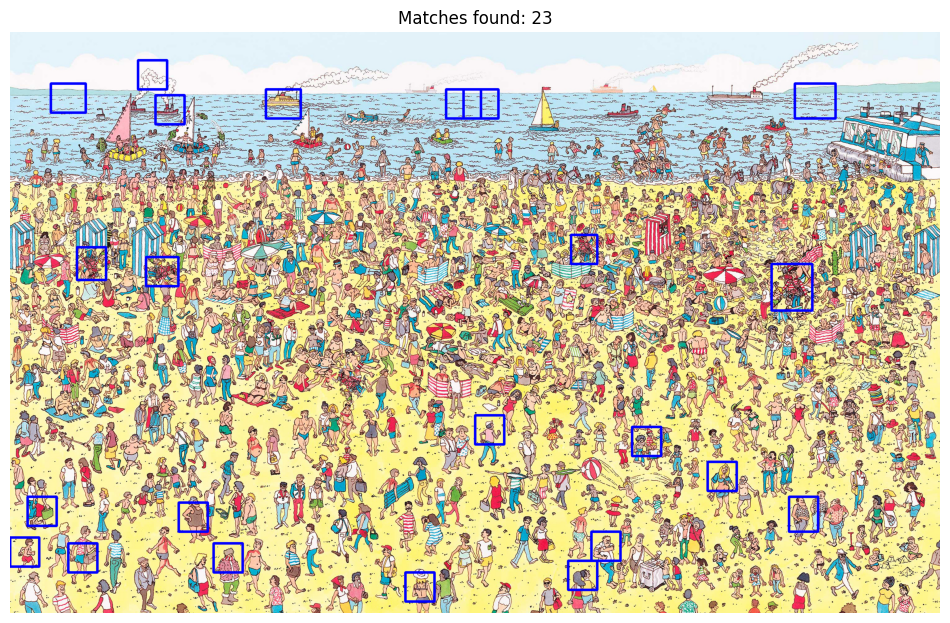

In [101]:
draw_all_matches(main_image_rgb, matches_pyramid)

In [105]:
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")
template_grey, main_image_grey = load_images(waldo_path, full_pic_path, read_gray=True)
processed_template_grey, processed_main_grey = preprocess_images(template_grey, main_image_grey)

matches_pyramid = pyramid_template_matching(
    processed_template_grey,
    processed_main_grey,
    num_levels=3,
    threshold=0.70,
    min_distance=40
)


 Matching at pyramid level 2 (scale x4)

 Matching at pyramid level 1 (scale x2)

 Matching at pyramid level 0 (scale x1)
amount of time took to look for all waldo configs = 6.921553373336792

 Total non-duplicate matches across pyramid: 5


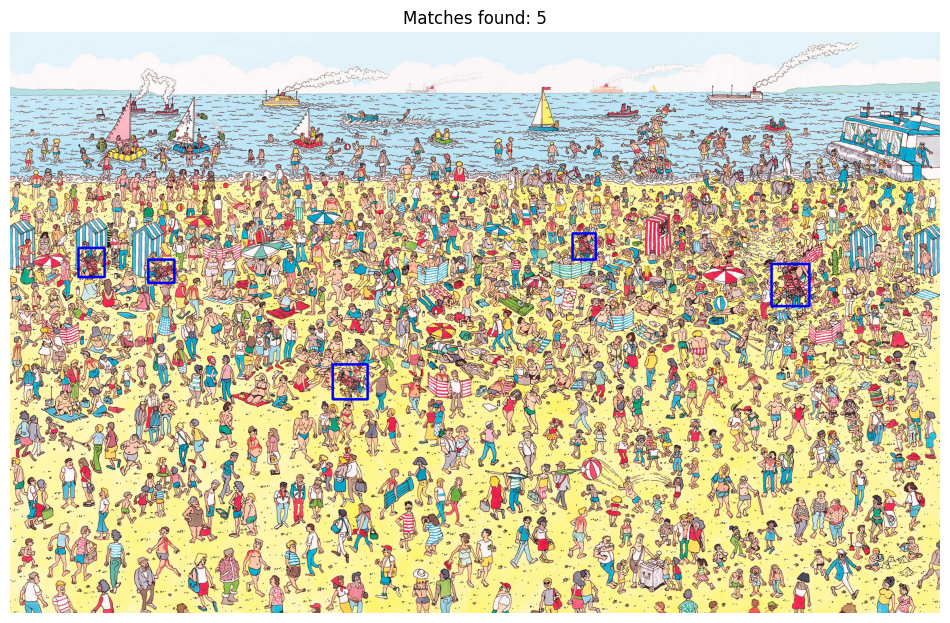

In [106]:
draw_all_matches(main_image_rgb, matches_pyramid)

In [115]:
waldo_path = os.path.join(dataset_dir, "template.png")
full_pic_path = os.path.join(dataset_dir, "waldo.png")
template_rgb, main_image_rgb = load_images(waldo_path, full_pic_path, read_gray=False)
processed_template_rgb, processed_main_rgb = preprocess_images(template_rgb, main_image_rgb)

matches_pyramid_new_rgb = pyramid_template_matching(
    processed_template_rgb,
    processed_main_rgb,
    num_levels=3,
    threshold=0.65,
    min_distance=40
)


 Matching at pyramid level 2 (scale x4)

 Matching at pyramid level 1 (scale x2)

 Matching at pyramid level 0 (scale x1)
amount of time took to look for all waldo configs = 19.604371070861816

 Total non-duplicate matches across pyramid: 5


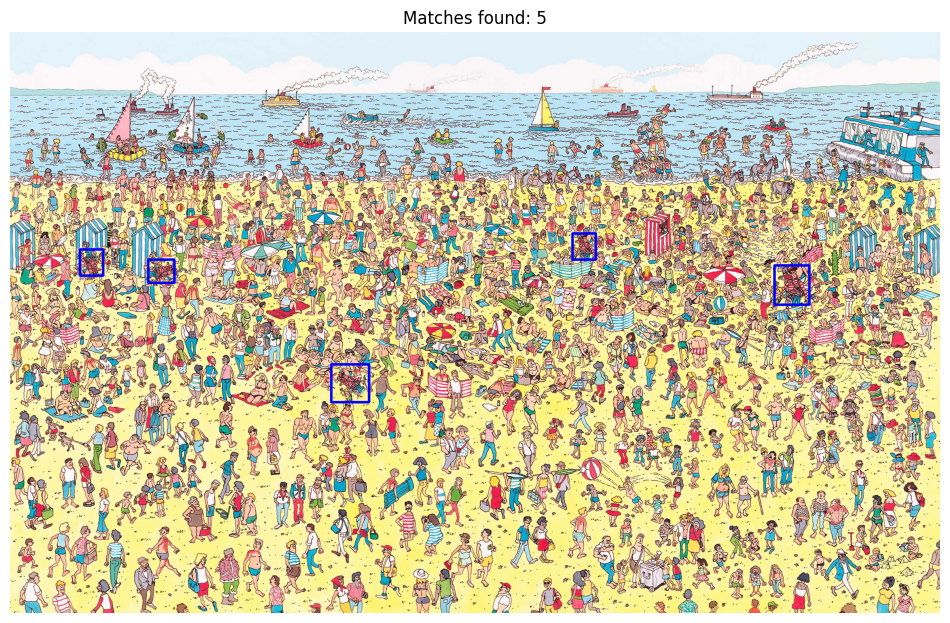

In [116]:
draw_all_matches(main_image_rgb, matches_pyramid_new_rgb)